In [1]:
import numpy as np
from numpy import pi
import pandas as pd
import scipy.optimize as optimize
from scipy import interpolate, integrate

import matplotlib as mpl
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation
from IPython.display import display, HTML, Video
import IPython

from numpy.polynomial.hermite import hermval
from math import factorial
from skimage import measure
import cv2
import finesse
from finesse.gaussian import HGMode

finesse.configure(plotting=True)

427521.0695534011j
(1.4480471766451293+0j)
1.0
(0.0010013722196150672+0j)


(0.9999997261477929+0j)

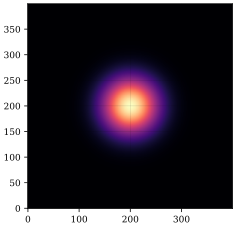

In [2]:
# w = 1
w = 1/2.628
q_0 = 1j*np.pi*w**2/(1064e-9) # at the waist
print(q_0)

x = y = np.linspace(-1, 1, 400)
step = x[1] - x[0]

HG00 = HGMode(q_0, n=0, m=0)
HG10 = HGMode(q_0, n=1, m=0)
HG20 = HGMode(q_0, n=2, m=0)
HG30 = HGMode(q_0, n=3, m=0)
HG40 = HGMode(q_0, n=4, m=0)
HG50 = HGMode(q_0, n=5, m=0)
HG60 = HGMode(q_0, n=6, m=0)


HG00_data = HG00.unm(x, y)
plt.imshow(np.abs(HG00_data)**2);
np.sum(HG00_data*HG00_data*step**2)

In [3]:
def BeatCoeff_HOM(n, rrange=0.5, num=50, plot=False, ax=None):
    HGn0 = HGMode(q_0, n=n, m=0)
    HGn0p = HGMode(q_0, n=n+1, m=0)
    
    HGn0HGn0p = lambda x: np.real(HGn0.un(x))*np.real(HGn0p.un(x))
    
    ds = w*np.linspace(0, rrange, num)
    HGn0HGn0p_data = []
    for d in ds:
        result, error = integrate.quad(HGn0HGn0p, d/2, np.inf) # d is the width of the gap
        if error > 1e-6:
            print(error)

        HGn0HGn0p_data.append(result*2)

    if plot:
        if ax:
            out = ax.plot(np.linspace(0, rrange, num), HGn0HGn0p_data)
            ax.set_title(rf"$\beta_{{{n}, {n+1}}}$", fontsize=16)
        else:
            out = plt.plot(np.linspace(0, rrange, num), HGn0HGn0p_data)
        return out
        
    return HGn0HGn0p_data

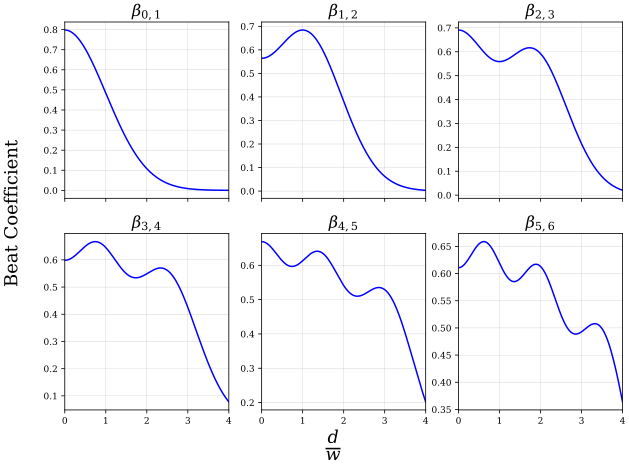

In [4]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, sharex=True, figsize=(10, 7))

BeatCoeff_HOM(0, rrange=4, num=200, plot=True, ax=ax0)
BeatCoeff_HOM(1, rrange=4, num=200, plot=True, ax=ax1)
BeatCoeff_HOM(2, rrange=4, num=200, plot=True, ax=ax2)
BeatCoeff_HOM(3, rrange=4, num=200, plot=True, ax=ax3)
BeatCoeff_HOM(4, rrange=4, num=200, plot=True, ax=ax4)
BeatCoeff_HOM(5, rrange=4, num=200, plot=True, ax=ax5)

# ax0.set_ylabel("Beat Coefficient", fontsize=16)
# ax3.set_ylabel("Beat Coefficient", fontsize=16)

# fig.tight_layout()
fig.supxlabel(r"$\frac{d}{w}$", fontsize=25, y=0.01)
fig.supylabel("Beat Coefficient", fontsize=18, x=0.04);
# fig.savefig('./beatCoeff.png', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [5]:
def WFSGAIN(n):
    if n == 0:
        return np.sqrt(n+1)*BC_list[n]
    else:
        return np.sqrt(n)*BC_list[n-1] + np.sqrt(n+1)*BC_list[n]

In [6]:
num_steps = 200#50
rrange = 1.5#0.7
BC_list = []
for n in range(7):
    bc = BeatCoeff_HOM(n, rrange=rrange, num=num_steps, plot=False)
    BC_list.append(bc)
BC_list = np.array(BC_list)

In [7]:
WFGAIN_data = []
for n in range(7):
    WFGAIN_data.append(WFSGAIN(n))
WFGAIN_data = np.array(WFGAIN_data)

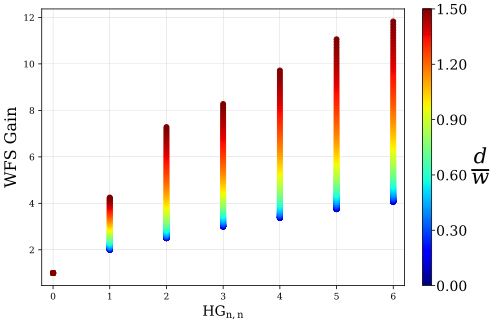

In [8]:
colors = cm.jet(np.linspace(0, 1, num_steps))
cmap = plt.cm.get_cmap('jet', num_steps)

fig, ax = plt.subplots(figsize=(7, 5))

ax.set_xlabel(r"$\mathrm{HG_{n,n}}$", fontsize=14)
ax.set_ylabel("WFS Gain", fontsize=16)
ax.set_xlim([-0.2, 6.2])

for n in range(num_steps):
    ax.plot(WFGAIN_data[:,n]/WFGAIN_data[0, n], '.', markersize=10, color=colors[n])
    
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.25)
cbar = plt.colorbar(sm, cax=cax, norm=mpl.colors.LogNorm(vmin=0, vmax=1))
cbar.set_label(label=r"$\frac{d}{w}$", fontsize=30, rotation=0, labelpad=15)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_ticklabels([f"{label:.2f}" for label in np.linspace(0, 1, 6)*rrange])
# cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);
# fig.savefig('./WFSgain_beamsize.png', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [9]:
def BeatCoeff_HOM_Smallw(n, rrange=0.5, num=50,):
    HGn0 = HGMode(q_0, n=n, m=0)
    HGn0p = HGMode(q_0, n=n+1, m=0)
    
    HGn0HGn0p = lambda x: np.real(HGn0.un(x))*np.real(HGn0p.un(x))
    
    ds = w*np.linspace(0, rrange, num)
    HGn0HGn0p_data = []
    for d in ds:
        result, error = integrate.quad(HGn0HGn0p, d/2, np.inf) # d is the width of the gap
        if error > 1e-6:
            print(error)

        HGn0HGn0p_data.append(result*2)

    return HGn0HGn0p_data

In [10]:

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#e41a1c', '#dede00', '#984ea3',
                  '#999999', '#f781bf', '#a65628']

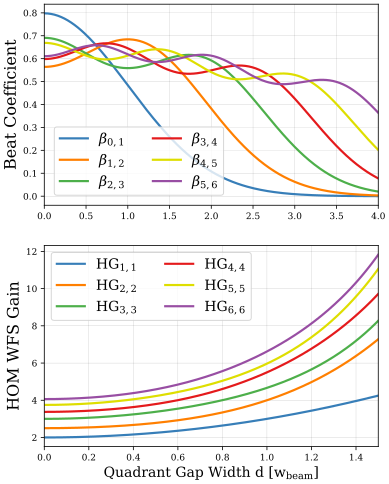

In [17]:
colors = cm.jet(np.linspace(0, 1, 6))
# cmap = plt.cm.get_cmap('jet', 6)
# ws = np.linspace(rrange_low*w0, rrange_high*w0, num_steps)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(6, 8))

rrange  = 4
num = 200
for n in range(6):
    HGn0HGn0p_data = BeatCoeff_HOM_Smallw(n, rrange=rrange, num=num)
    ax1.plot(np.linspace(0, rrange, num), HGn0HGn0p_data, lw=2.2, label=rf"$\beta_{{{n}, {n+1}}}$", color=CB_color_cycle[n])

handles, labels = ax1.get_legend_handles_labels()
legend = ax1.legend(handles, labels, fontsize=14, ncols=2, loc=(0.03, 0.05));
# ax1.add_artist(legend)

for n in range(1,7):
    ax2.plot(np.linspace(0, 1.5, 200), WFGAIN_data[n,:]/WFGAIN_data[0,:], lw=2.2,
             color=CB_color_cycle[n-1], label=f"$\mathrm{{HG}}_{{{n},{n}}}$")

ax2.set_xlabel(r"Quadrant Gap Width d [$\mathrm{w_{beam}}$]", fontsize=14)
ax1.set_ylabel("Beat Coefficient", fontsize=16)
ax2.set_ylabel("HOM WFS Gain", fontsize=16)
# ax2.set_xticks(np.linspace(0, 1, 6)*1.5)
plt.legend(fontsize=14, ncols=2, loc="best");
# fig.savefig('./Experiment Paper/WFSGainQPDGapSize.pdf', \
#             bbox_inches='tight', dpi=300, pad_inches=0.01);

# fig.savefig('/Users/liutao/Desktop/Thesis/Experiment/WFSGainQPDGapSize.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);


In [94]:
# w = 1/2.628
# def BeatCoeff_HOM_Aperture_p(n, rrange_low=0.5, rrange=2, num_steps=5):
#     HGn0 = HGMode(q_0, m=n, n=n)
#     HGn0p = HGMode(q_0, m=n+1, n=n)

#     HGn0HGn0p = lambda x, y: np.real(HGn0.unm(x, y))*np.real(HGn0p.unm(x, y))

#     HGn0HGn0p_data = []
#     Rs = np.linspace(rrange_low*w, rrange, num_steps)
#     for R in Rs:
#         result, error = integrate.dblquad(HGn0HGn0p, 0, R, 0, lambda x: np.sqrt(R**2-x**2))
#         if error > 1e-6:
#             print(error)

#         HGn0HGn0p_data.append(4*result)
        
#     return HGn0HGn0p_data


# def BeatCoeff_HOM_Aperture_n(n, rrange_low=0.5, rrange=2, num_steps=5):
#     HGn0 = HGMode(q_0, m=n, n=n+1)
#     HGn0p = HGMode(q_0, m=n+1, n=n+1)

#     HGn0HGn0p = lambda x, y: np.real(HGn0.unm(x, y))*np.real(HGn0p.unm(x, y))

#     HGn0HGn0p_data = []
#     Rs = np.linspace(rrange_low*w, rrange, num_steps)
#     for R in Rs:
#         result, error = integrate.dblquad(HGn0HGn0p, 0, R, 0, lambda x: np.sqrt(R**2-x**2))
#         if error > 1e-6:
#             print(error)

#         HGn0HGn0p_data.append(4*result)
        
#     return HGn0HGn0p_data

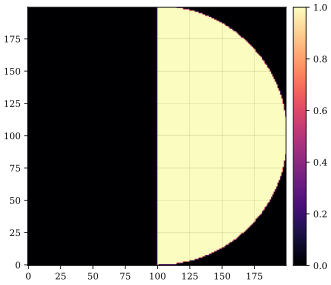

In [3]:
def HG_mirror_func(shapex=200, shapey=200, plot=False):
    HG_mirror = np.zeros((int(shapex), int(shapey)))
    center = [shapex / 2, shapey / 2]
    r = center[0]
    x = np.arange(shapex)
    y = np.arange(shapey)
    xv, yv = np.meshgrid(x, y)

    index = (((xv - center[0]))**2 + ((yv - center[1]))**2 <= r**2)&((xv - center[0])>=0)
    HG_mirror[index] = 1.

    if plot:
        plt.figure(figsize=(5, 5))
        ax = plt.gca()
        im = ax.imshow(HG_mirror)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)

        plt.colorbar(im, cax=cax)

    return HG_mirror

HG_mirror = HG_mirror_func(plot=True)

In [4]:
w0 = 1/2.628
x = y = np.linspace(-1, 1, 200)
# xx, yy = np.meshgrid(x, x, sparse=True)
delta = x[1] - x[0]
rrange_low = 0.2
rrange_high = 3
num_steps = 200
def BeatCoeff_HOM_Aperture(n, rrange_low=rrange_low, rrange_high=rrange_high, num_steps=num_steps):
    beatcoeff_ps = []
    beatcoeff_ns = []
    ws = np.linspace(rrange_low*w0, rrange_high*w0, num_steps)
    for w in ws:
        q_ = 1j*np.pi*w**2/(1064e-9)
        HGnn = HGMode(q_, m=n, n=n)
        HGnnp = HGMode(q_, m=n+1, n=n)  
        HGnn_data = np.real(HGnn.unm(x, y))*HG_mirror
        HGnnp_data = np.real(HGnnp.unm(x, y))*HG_mirror
        beatcoeff_p = np.sum(HGnn_data*HGnnp_data)*delta**2*2
        
        if n >= 1:
            HGnnn = HGMode(q_, m=n-1, n=n)
            HGnnn_data = np.real(HGnnn.unm(x, y))*HG_mirror             
            beatcoeff_n = np.sum(HGnn_data*HGnnn_data)*delta**2*2
            beatcoeff_ns.append(beatcoeff_n)
        
        beatcoeff_ps.append(beatcoeff_p)
        
    return beatcoeff_ps, beatcoeff_ns

In [5]:
beatcoeff_pss = np.empty((num_steps,7))
beatcoeff_nss = np.empty((num_steps,7))
beatcoeff_nss[:,0] = 0

for n in range(7):
    beatcoeff_ps, beatcoeff_ns = BeatCoeff_HOM_Aperture(n, num_steps=num_steps)
    beatcoeff_pss[:, n] = beatcoeff_ps
    if n >= 1:
        beatcoeff_nss[:, n] = beatcoeff_ns

(3.2379319216051545+0j)
1.0
(1.0348763743941651e-75+0j)
(3.2379319216051545+0j)
1.0
(1.0348763743941651e-75+0j)
(3.1297125388561087+0j)
1.0
(3.5329766376247093e-66+0j)
(3.1297125388561087+0j)
1.0
(3.5329766376247093e-66+0j)
(3.0316657890764116+0j)
1.0
(2.3579777554203735e-58+0j)
(3.0316657890764116+0j)
1.0
(2.3579777554203735e-58+0j)
(2.9422917244818323+0j)
1.0
(7.470966829111528e-52+0j)
(2.9422917244818323+0j)
1.0
(7.470966829111528e-52+0j)
(2.860382822768337+0j)
1.0
(2.1536412957690976e-46+0j)
(2.860382822768337+0j)
1.0
(2.1536412957690976e-46+0j)
(2.7849545474663424+0j)
1.0
(9.181267615311567e-42+0j)
(2.7849545474663424+0j)
1.0
(9.181267615311567e-42+0j)
(2.715195053585297+0j)
1.0
(8.36914316949334e-38+0j)
(2.715195053585297+0j)
1.0
(8.36914316949334e-38+0j)
(2.65042809747192+0j)
1.0
(2.166706985965325e-34+0j)
(2.65042809747192+0j)
1.0
(2.166706985965325e-34+0j)
(2.590085240289317+0j)
1.0
(1.988116792829647e-31+0j)
(2.590085240289317+0j)
1.0
(1.988116792829647e-31+0j)
(2.53368471273

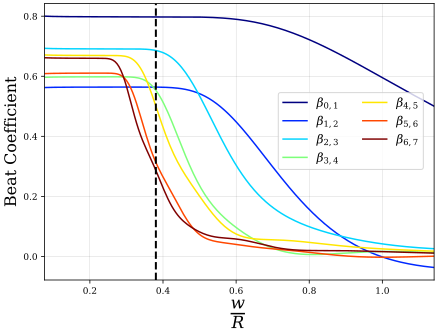

In [6]:
colors = cm.jet(np.linspace(0, 1, 7))
cmap = plt.cm.get_cmap('jet', 7)
ws = np.linspace(rrange_low*w0, rrange_high*w0, num_steps)

fig, ax = plt.subplots(figsize=(7, 5))

ax.set_xlabel(r"$\frac{w}{R}$", fontsize=24)
ax.set_ylabel("Beat Coefficient", fontsize=16)
for n in range(7):
    ax.plot(ws, beatcoeff_pss[:, n], color=colors[n], label=rf"$\beta_{{{n}, {n+1}}}$")
    
# for n in range(7):
#     if n >= 1:
#         ax.plot(ws, beatcoeff_nss[:, n], color=colors[n+6], label=rf"$\beta^n_{{{n}, {n-1}}}$")

ax.axvline(x=w0, color="k", linestyle="--", lw=2)

plt.legend(fontsize=12, ncols=2, loc=(0.6, 0.4));
# fig.savefig('./BeatCoeff_R.png', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [7]:
def WFSGAIN(n, beatcoeff_pss, beatcoeff_nss):
    if n == 0:
        return np.sqrt(n+1)*beatcoeff_pss[:, n]
    else:
        return np.sqrt(n)*beatcoeff_nss[:, n] + np.sqrt(n+1)*beatcoeff_pss[:, n]

In [8]:
beatcoeff_pss_ = np.empty((num_steps,7))
beatcoeff_nss_ = np.empty((num_steps,7))
beatcoeff_nss_[:,0] = 0

for n in range(7):
    beatcoeff_ps, beatcoeff_ns = BeatCoeff_HOM_Aperture(n, rrange_high=1.5, num_steps=num_steps)
    beatcoeff_pss_[:, n] = beatcoeff_ps
    if n >= 1:
        beatcoeff_nss_[:, n] = beatcoeff_ns

WFGAIN_data = []
for n in range(7):
    WFGAIN_data.append(WFSGAIN(n, beatcoeff_pss_, beatcoeff_nss_))
WFGAIN_data = np.array(WFGAIN_data)

(3.2379319216051545+0j)
1.0
(1.0348763743941651e-75+0j)
(3.2379319216051545+0j)
1.0
(1.0348763743941651e-75+0j)
(3.1863122882652712+0j)
1.0
(4.824496435376429e-71+0j)
(3.1863122882652712+0j)
1.0
(4.824496435376429e-71+0j)
(3.137085252344336+0j)
1.0
(8.495992051386232e-67+0j)
(3.137085252344336+0j)
1.0
(8.495992051386232e-67+0j)
(3.0900715169946777+0j)
1.0
(6.334743620430848e-63+0j)
(3.0900715169946777+0j)
1.0
(6.334743620430848e-63+0j)
(3.0451100492144088+0j)
1.0
(2.2054551981173166e-59+0j)
(3.0451100492144088+0j)
1.0
(2.2054551981173166e-59+0j)
(3.0020557554440477+0j)
1.0
(3.900689785553566e-56+0j)
(3.0020557554440477+0j)
1.0
(3.900689785553566e-56+0j)
(2.9607775087903416+0j)
1.0
(3.7700488802465657e-53+0j)
(2.9607775087903416+0j)
1.0
(3.7700488802465657e-53+0j)
(2.9211564666939522+0j)
1.0
(2.1215241906462217e-50+0j)
(2.9211564666939522+0j)
1.0
(2.1215241906462217e-50+0j)
(2.883084629821516+0j)
1.0
(7.346140722409496e-48+0j)
(2.883084629821516+0j)
1.0
(7.346140722409496e-48+0j)
(2.846

In [9]:
for n in range(7):
    beatcoeff_ps, beatcoeff_ns = BeatCoeff_HOM_Aperture(n, num_steps=num_steps)
    beatcoeff_pss[:, n] = beatcoeff_ps
    if n >= 1:
        beatcoeff_nss[:, n] = beatcoeff_ns

WFGAIN_data_30per = []
beatcoeff_p_30per = []
beatcoeff_n_30per = [0,]
w_1 = 0.3
for n in range(7):
    q_ = 1j*np.pi*w_1**2/(1064e-9)
    HGnn = HGMode(q_, m=n, n=n)
    HGnnp = HGMode(q_, m=n+1, n=n)  
    HGnn_data = np.real(HGnn.unm(x, y))*HG_mirror
    HGnnp_data = np.real(HGnnp.unm(x, y))*HG_mirror
    beatcoeff_p = np.sum(HGnn_data*HGnnp_data)*delta**2*2
    beatcoeff_p_30per.append(beatcoeff_p)

    if n >= 1:
        HGnnn = HGMode(q_, m=n-1, n=n)
        HGnnn_data = np.real(HGnnn.unm(x, y))*HG_mirror             
        beatcoeff_n = np.sum(HGnn_data*HGnnn_data)*delta**2*2
        beatcoeff_n_30per.append(beatcoeff_n)

def WFSGAIN_30per(n):
    if n == 0:
        return np.sqrt(n+1)*beatcoeff_p_30per[n]
    else:
        return np.sqrt(n)*beatcoeff_n_30per[n] + np.sqrt(n+1)*beatcoeff_p_30per[n]
for n in range(7):
    WFGAIN_data_30per.append(WFSGAIN_30per(n))
WFGAIN_data_30per = np.array(WFGAIN_data_30per)

(3.2379319216051545+0j)
1.0
(1.0348763743941651e-75+0j)
(3.2379319216051545+0j)
1.0
(1.0348763743941651e-75+0j)
(3.1297125388561087+0j)
1.0
(3.5329766376247093e-66+0j)
(3.1297125388561087+0j)
1.0
(3.5329766376247093e-66+0j)
(3.0316657890764116+0j)
1.0
(2.3579777554203735e-58+0j)
(3.0316657890764116+0j)
1.0
(2.3579777554203735e-58+0j)
(2.9422917244818323+0j)
1.0
(7.470966829111528e-52+0j)
(2.9422917244818323+0j)
1.0
(7.470966829111528e-52+0j)
(2.860382822768337+0j)
1.0
(2.1536412957690976e-46+0j)
(2.860382822768337+0j)
1.0
(2.1536412957690976e-46+0j)
(2.7849545474663424+0j)
1.0
(9.181267615311567e-42+0j)
(2.7849545474663424+0j)
1.0
(9.181267615311567e-42+0j)
(2.715195053585297+0j)
1.0
(8.36914316949334e-38+0j)
(2.715195053585297+0j)
1.0
(8.36914316949334e-38+0j)
(2.65042809747192+0j)
1.0
(2.166706985965325e-34+0j)
(2.65042809747192+0j)
1.0
(2.166706985965325e-34+0j)
(2.590085240289317+0j)
1.0
(1.988116792829647e-31+0j)
(2.590085240289317+0j)
1.0
(1.988116792829647e-31+0j)
(2.53368471273

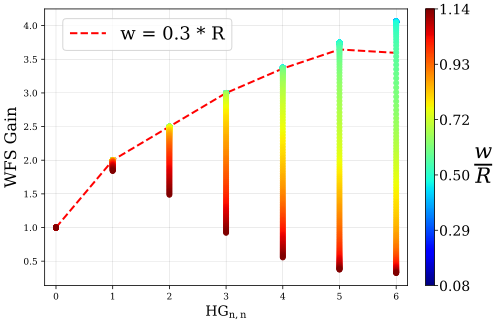

In [10]:
colors = cm.jet(np.linspace(0, 1, num_steps))
cmap = plt.cm.get_cmap('jet', num_steps)

fig, ax = plt.subplots(figsize=(7, 5))

ax.set_xlabel(r"$\mathrm{HG_{n,n}}$", fontsize=14)
ax.set_ylabel("WFS Gain", fontsize=16)
ax.set_xlim([-0.2, 6.2])
ax.plot(WFGAIN_data_30per/WFGAIN_data_30per[0], "r--", lw=2, label="w = 0.3 * R")
# ax.set_ylim([0.8, 5.2])
plt.legend(fontsize=18, ncols=2, loc=(0.05, 0.85))

for n in range(num_steps):
    ax.plot(WFGAIN_data[:,n]/WFGAIN_data[0, n], '.', markersize=10, color=colors[n])
    
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.25)
cbar = plt.colorbar(sm, cax=cax, norm=mpl.colors.LogNorm(vmin=0, vmax=1))
cbar.set_label(label=r"$\frac{w}{R}$", fontsize=30, rotation=0, labelpad=15)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_ticklabels([f"{label:.2f}" for label in np.linspace(rrange_low*w0, rrange_high*w0, 6)])
# cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);
# fig.savefig('./WFGAIN_R.png', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [12]:

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

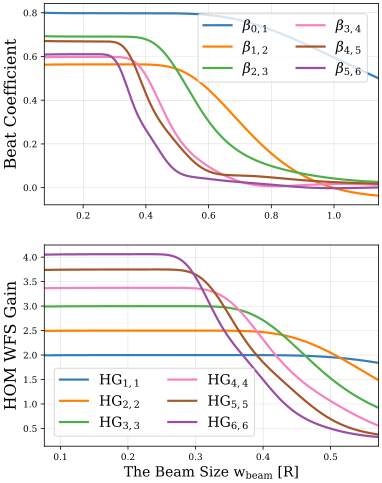

In [15]:
colors = cm.jet(np.linspace(0, 1, 6))
ws = np.linspace(rrange_low*w0, 3*w0, num_steps)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(6, 8))

rrange  = 4
num = 200
for n in range(6):
    ax1.plot(ws, beatcoeff_pss[:, n], lw=2.2, label=rf"$\beta_{{{n}, {n+1}}}$", color=CB_color_cycle[n])

handles, labels = ax1.get_legend_handles_labels()
legend = ax1.legend(handles, labels, fontsize=14, ncols=2, loc=(0.46, 0.61));
# ax1.add_artist(legend)

ws = np.linspace(rrange_low*w0, 1.5*w0, num_steps)
for n in range(1,7):
    ax2.plot(ws, WFGAIN_data[n,:]/WFGAIN_data[0,:], lw=2.2,
             color=CB_color_cycle[n-1], label=f"$\mathrm{{HG}}_{{{n},{n}}}$")

# ax2.set_xlabel(r"$\frac{w}{R}$", fontsize=24)
ax2.set_xlabel(r"The Beam Size $\mathrm{w_{beam}}$ [R]", fontsize=14)

ax1.set_ylabel("Beat Coefficient", fontsize=16)
ax2.set_ylabel("HOM WFS Gain", fontsize=16)
plt.legend(fontsize=14, ncols=2, loc=(0.03, 0.05));
# fig.savefig('./Experiment Paper/WFSGainQPDApertureSize.pdf', \
#             bbox_inches='tight', dpi=300, pad_inches=0.01);

# fig.savefig('/Users/liutao/Desktop/Thesis/Experiment/WFSGainQPDApertureSize.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);
